# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# Define

In this project we have access to the Starbucks dataset that allows us to see users, different offers and the interactions that users do with the offers as well as the transactions.

Actually there are 10 different offers that have been created to propose to the customers and they have been sent to users during an experiment.

We don't know yet how good are the offers that were created and in which group of users they work better.
In order to get some useful information in this context, let's explore this data to then clean it and propose a model that can learn from it and then help us to know if an offer sent to a specific type of customer will actually work or not.

# Analyze

Let's start with the data exploration and cleaning.

## Exploring and Cleaning Data

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

In [2]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

Here we are going to explore and clean the data by table.

### Portfolio table 

In [3]:
portfolio.shape

(10, 6)

In [4]:
portfolio.head(15)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


We have 10 different offers in the portfolio and it might be useful to separate the channels into different columns.

In [5]:
dict_channels = ['web', 'email', 'mobile', 'social']
channels = portfolio.channels.apply(lambda row:pd.Series([1 if i in row else 0 for i in dict_channels]))
portfolio[dict_channels] = channels
portfolio.drop(columns='channels', inplace=True)

In [6]:
portfolio

,difficulty,duration,id,offer_type,reward,web,email,mobile,social
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,1,0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,1,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,1,0,0
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,1,1,1
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,1,0


In [7]:
portfolio = portfolio.join(pd.get_dummies(portfolio.offer_type)).drop(columns='offer_type')

In [8]:
portfolio

,difficulty,duration,id,reward,web,email,mobile,social,bogo,discount,informational
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,4,3f207df678b143eea3cee63160fa8bed,0,1,1,1,0,0,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,1,0,1,0,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,1,0,0,0,1,0
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,3,1,1,1,1,0,1,0
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,2,1,1,1,1,0,1,0
7,0,3,5a8bc65990b245e5a138643cd4eb9837,0,0,1,1,1,0,0,1
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,5,1,1,1,1,1,0,0
9,10,7,2906b810c7d4411798c6938adc9daaa5,2,1,1,1,0,0,1,0


### Profile table

In [9]:
profile.shape

(17000, 5)

In [10]:
profile.head(10)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN


In [11]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [12]:
profile.age.unique()

array([118,  55,  75,  68,  65,  58,  61,  26,  62,  49,  57,  40,  64,
        78,  42,  56,  33,  46,  59,  67,  53,  22,  96,  69,  20,  45,
        54,  39,  41,  79,  66,  29,  44,  63,  36,  76,  77,  30,  51,
        27,  73,  74,  70,  89,  50,  90,  60,  19,  72,  52,  18,  71,
        83,  43,  47,  32,  38,  34,  85,  48,  35,  82,  21,  24,  81,
        25,  37,  23, 100,  28,  84,  80,  87,  86,  94,  31,  88,  95,
        93,  91,  92,  98, 101,  97,  99])

In [13]:
profile.groupby('age').count().tail(10)

,became_member_on,gender,id,income
age,,,,
93,29,29,29,29
94,33,33,33,33
95,22,22,22,22
96,8,8,8,8
97,13,13,13,13
98,5,5,5,5
99,5,5,5,5
100,12,12,12,12
101,5,5,5,5


There is the age 118 that seems to be the default value in the register form, I imagine it propose the year 1900 and the age calculation was made in 2018. Let's take a closer look to this to see if there is interesting data coming from those profiles. Because a priori it looks like those profiles don't specify income nor gender.

In [14]:
profile.duplicated().sum()

0

In [15]:
age_118 = profile[profile['age'] == 118]

In [16]:
age_118.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 16994
Data columns (total 5 columns):
age                 2175 non-null int64
became_member_on    2175 non-null int64
gender              0 non-null object
id                  2175 non-null object
income              0 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 102.0+ KB


We can see that all the users with age 118 have no data in the gender and income columns.
We will see if they have interactions with the offers.

### Transcript table

In [17]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [19]:
transcript.shape

(306534, 4)

In [20]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [21]:
transcript.time.unique()

array([  0,   6,  12,  18,  24,  30,  36,  42,  48,  54,  60,  66,  72,
        78,  84,  90,  96, 102, 108, 114, 120, 126, 132, 138, 144, 150,
       156, 162, 168, 174, 180, 186, 192, 198, 204, 210, 216, 222, 228,
       234, 240, 246, 252, 258, 264, 270, 276, 282, 288, 294, 300, 306,
       312, 318, 324, 330, 336, 342, 348, 354, 360, 366, 372, 378, 384,
       390, 396, 402, 408, 414, 420, 426, 432, 438, 444, 450, 456, 462,
       468, 474, 480, 486, 492, 498, 504, 510, 516, 522, 528, 534, 540,
       546, 552, 558, 564, 570, 576, 582, 588, 594, 600, 606, 612, 618,
       624, 630, 636, 642, 648, 654, 660, 666, 672, 678, 684, 690, 696,
       702, 708, 714])

In [22]:
transcript[transcript['person'].isin(age_118.id)].shape

(33772, 4)

About 10 percent of the interactions of users with offers are made by non well identified users (118 years old). This data might still be useful for general behaviour analysis, but since we will focus into demographic factors let's drop all the users and interactions for the 118 years old.

In [23]:
transcript = transcript[~transcript['person'].isin(age_118.id)]
transcript.shape

(272762, 4)

In [24]:
profile = profile[profile['age'] < 118]
profile.shape

(14825, 5)

## Wrangring data

We want to characterize the behaviour of the users and see how this is affected by the offers and their demographic factors.

In order to accomplish our goal we will:
- Define the features that can be interesting.
- Create our dataset.
- Merge it in one useful table.

### Define our features

In first place let's considere the characteristic of the user as features. What we have available are Gender, Age and Income.

The user is not the only factor that might determine if a costumer will do a transaction or not, the offer that is proposed seems to be very important too. So, to include this element let's considere some details of the offer itself and not only the offer type as a variable.
In this context we have available, difficulty, duration, offer_type, reward, web, email, mobile and social.

### Create our dataset

Let's create our dataset where every row will be a combination of user and viewed offer, in order to see if the viewed offers are completed or not.

In [25]:
viewed_offers = transcript[transcript['event'] == 'offer viewed'].copy()
viewed_offers.value = viewed_offers.value.apply(lambda x: dict(x)['offer id'])
viewed_offers.head()

,event,person,time,value
12650,offer viewed,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d
12651,offer viewed,d1ede868e29245ea91818a903fec04c6,0,5a8bc65990b245e5a138643cd4eb9837
12652,offer viewed,102e9454054946fda62242d2e176fdce,0,4d5c57ea9a6940dd891ad53e9dbe8da0
12653,offer viewed,02c083884c7d45b39cc68e1314fec56c,0,ae264e3637204a6fb9bb56bc8210ddfd
12655,offer viewed,be8a5d1981a2458d90b255ddc7e0d174,0,5a8bc65990b245e5a138643cd4eb9837


In [26]:
completed_offers = transcript[transcript['event'] == 'offer completed'].copy()
completed_offers.value = completed_offers.value.apply(lambda x: dict(x)['offer_id'])

In [27]:
viewed_offers.drop_duplicates(['value', 'person'], keep='first', inplace=True)
completed_offers.drop_duplicates(['value', 'person'], keep='first', inplace=True)

In [28]:
to_join = pd.DataFrame(completed_offers[['value', 'person']]).copy()
to_join['completed_offer'] = 1
to_join.head()

,value,person,completed_offer
12658,2906b810c7d4411798c6938adc9daaa5,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,1
12672,fafdcd668e3743c1bb461111dcafc2a4,fe97aa22dd3e48c8b143116a8403dd52,1
12679,9b98b8c7a33c4b65b9aebfe6a799e6d9,629fc02d56414d91bca360decdfa9288,1
12692,ae264e3637204a6fb9bb56bc8210ddfd,676506bad68e4161b9bbaffeb039626b,1
12697,4d5c57ea9a6940dd891ad53e9dbe8da0,8f7dd3b2afe14c078eb4f6e6fe4ba97d,1


In [29]:
user_offers = pd.merge(viewed_offers, to_join, how='left')

In [30]:
user_offers.completed_offer.fillna(0, inplace=True)
user_offers.head()

,event,person,time,value,completed_offer
0,offer viewed,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,1.0
1,offer viewed,d1ede868e29245ea91818a903fec04c6,0,5a8bc65990b245e5a138643cd4eb9837,0.0
2,offer viewed,102e9454054946fda62242d2e176fdce,0,4d5c57ea9a6940dd891ad53e9dbe8da0,1.0
3,offer viewed,02c083884c7d45b39cc68e1314fec56c,0,ae264e3637204a6fb9bb56bc8210ddfd,0.0
4,offer viewed,be8a5d1981a2458d90b255ddc7e0d174,0,5a8bc65990b245e5a138643cd4eb9837,0.0


In [31]:
user_offers.drop(columns=['event', 'time'], inplace=True)
user_offers.completed_offer = user_offers.completed_offer.astype(int)

In [32]:
user_offers.head()

,person,value,completed_offer
0,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,1
1,d1ede868e29245ea91818a903fec04c6,5a8bc65990b245e5a138643cd4eb9837,0
2,102e9454054946fda62242d2e176fdce,4d5c57ea9a6940dd891ad53e9dbe8da0,1
3,02c083884c7d45b39cc68e1314fec56c,ae264e3637204a6fb9bb56bc8210ddfd,0
4,be8a5d1981a2458d90b255ddc7e0d174,5a8bc65990b245e5a138643cd4eb9837,0


### Merge in one table

In [33]:
user_offers = pd.merge(user_offers, profile, how='left', left_on='person', right_on='id')

In [34]:
user_offers.head()

,person,value,completed_offer,age,became_member_on,gender,id,income
0,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,1,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
1,d1ede868e29245ea91818a903fec04c6,5a8bc65990b245e5a138643cd4eb9837,0,53,20170916,O,d1ede868e29245ea91818a903fec04c6,52000.0
2,102e9454054946fda62242d2e176fdce,4d5c57ea9a6940dd891ad53e9dbe8da0,1,69,20160814,F,102e9454054946fda62242d2e176fdce,57000.0
3,02c083884c7d45b39cc68e1314fec56c,ae264e3637204a6fb9bb56bc8210ddfd,0,20,20160711,F,02c083884c7d45b39cc68e1314fec56c,30000.0
4,be8a5d1981a2458d90b255ddc7e0d174,5a8bc65990b245e5a138643cd4eb9837,0,39,20140527,M,be8a5d1981a2458d90b255ddc7e0d174,51000.0


In [35]:
user_offers.drop(columns='id', inplace=True)

In [36]:
user_offers = pd.merge(user_offers, portfolio, how='left', left_on='value', right_on='id')
user_offers.head()

,person,value,completed_offer,age,became_member_on,gender,income,difficulty,duration,id,reward,web,email,mobile,social,bogo,discount,informational
0,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,1,65,20180209,M,53000.0,5,5,f19421c1d4aa40978ebb69ca19b0e20d,5,1,1,1,1,1,0,0
1,d1ede868e29245ea91818a903fec04c6,5a8bc65990b245e5a138643cd4eb9837,0,53,20170916,O,52000.0,0,3,5a8bc65990b245e5a138643cd4eb9837,0,0,1,1,1,0,0,1
2,102e9454054946fda62242d2e176fdce,4d5c57ea9a6940dd891ad53e9dbe8da0,1,69,20160814,F,57000.0,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
3,02c083884c7d45b39cc68e1314fec56c,ae264e3637204a6fb9bb56bc8210ddfd,0,20,20160711,F,30000.0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,0
4,be8a5d1981a2458d90b255ddc7e0d174,5a8bc65990b245e5a138643cd4eb9837,0,39,20140527,M,51000.0,0,3,5a8bc65990b245e5a138643cd4eb9837,0,0,1,1,1,0,0,1


In [37]:
user_offers.drop(columns='id', inplace=True)

In [38]:
dataset = user_offers.drop(columns=['person', 'value', 'became_member_on'])

In [39]:
dataset.head()

,completed_offer,age,gender,income,difficulty,duration,reward,web,email,mobile,social,bogo,discount,informational
0,1,65,M,53000.0,5,5,5,1,1,1,1,1,0,0
1,0,53,O,52000.0,0,3,0,0,1,1,1,0,0,1
2,1,69,F,57000.0,10,5,10,1,1,1,1,1,0,0
3,0,20,F,30000.0,10,7,10,0,1,1,1,1,0,0
4,0,39,M,51000.0,0,3,0,0,1,1,1,0,0,1


In [40]:
dataset = dataset.join(pd.get_dummies(dataset.gender)).drop(columns='gender')

In [41]:
dataset = dataset.drop(columns=['O', 'informational'])
dataset.head()

,completed_offer,age,income,difficulty,duration,reward,web,email,mobile,social,bogo,discount,F,M
0,1,65,53000.0,5,5,5,1,1,1,1,1,0,0,1
1,0,53,52000.0,0,3,0,0,1,1,1,0,0,0,0
2,1,69,57000.0,10,5,10,1,1,1,1,1,0,1,0
3,0,20,30000.0,10,7,10,0,1,1,1,1,0,1,0
4,0,39,51000.0,0,3,0,0,1,1,1,0,0,0,1


### Propose a machine learning classification model.

Let's use a Logistic regression model to predict if a specific offer sent to a specific user is going to be completed or not.

In [91]:
X = dataset.iloc[:,1:]
y = dataset['completed_offer']

In [92]:
dataset.head()

,completed_offer,age,income,difficulty,duration,reward,web,email,mobile,social,bogo,discount,F,M
0,1,65,53000.0,5,5,5,1,1,1,1,1,0,0,1
1,0,53,52000.0,0,3,0,0,1,1,1,0,0,0,0
2,1,69,57000.0,10,5,10,1,1,1,1,1,0,1,0
3,0,20,30000.0,10,7,10,0,1,1,1,1,0,1,0
4,0,39,51000.0,0,3,0,0,1,1,1,0,0,0,1


Let's see if we can reduce the amount of features in order to get a better model from the beginning.

In [93]:
logreg = LogisticRegression()
rfe = RFE(logreg)
rfe = rfe.fit(X, y)
print(rfe.support_)
print(rfe.ranking_)

[False False False False False False  True  True  True  True  True False
  True]
[6 8 4 3 7 2 1 1 1 1 1 5 1]


After applying RFE we can see that the 'income' variable is not very good as a feature so let's eliminate it from the model as well as the variable reward. So that we eliminate one variable from the users and one from the offers. 

In [94]:
dataset.columns

Index(['completed_offer', 'age', 'income', 'difficulty', 'duration', 'reward',
       'web', 'email', 'mobile', 'social', 'bogo', 'discount', 'F', 'M'],
      dtype='object')

In [95]:
cols=['age', 'difficulty', 'duration', 'web', 'email', 'mobile', 'social', 'bogo', 'discount', 'F', 'M']

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.70


In [97]:
X=X[cols]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.77


We can see that eliminating those two features improves the accuracy of the model in 6%.

In [53]:
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[3157 2522]
 [ 470 6599]]


So out of a universe of 12748, 9756 user-offre combinations are well predicted.

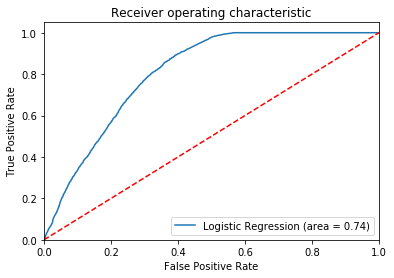

In [55]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Here we can see a big logistic regression area in the ROC. Which shows us how good the model is.

Now we have a model that can help us know, given a combination of user, offre, if this will produce a completed offre.

This model presents a 77% of accuracy and it is a good approach to asses the creation of new offer-user combinations. This allows to propose more specific offers for customers according with their characteristics.

More details about the conclusions will be given in the article in Medium.com whose link can be found in the README.md